In [1]:
#importing necessary modules

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import datetime
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import matplotlib.pyplot as plt
import datetime
from torch import Tensor
from torch.nn import Linear

random.seed(10)

In [2]:
   def prepare_data(datafile):
    #Put the file location
    df = pd.read_csv(datafile)

    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)
    df = df[["lat_grid", "long_grid", "pm2_5"]]
    df = df.groupby(['lat_grid', 'long_grid']).mean().reset_index()
    df = df.pivot_table(index=['lat_grid', 'long_grid'])
    
#     # rounding @120min
#     df.dateTime = pd.to_datetime(df.dateTime)
#     df.dateTime = df.dateTime.dt.round('120min')
#     # use time as a feature as well
#     df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute

#     # only PM2_5
#     df = df[['dateTime','lat_grid','long_grid','pm2_5']]
#     df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
#     df = df.fillna(0)
#     df = df.mean(axis = 1).to_frame(name = 'pm2_5')
    
    return df

In [3]:
def train_test_split(df, grid_points_indices, train_size):
    #train-data for range from total grid structure
#     train_size = 0.8
#     random.seed(10)
    points_len = df.shape[0]
    test_size = int(points_len * (1-train_size))
    test_indices = random.sample(list(df.index), test_size)
    train_indices = list(set(df.index) - set(test_indices))

    train_data = df.loc[train_indices, :]
    train_data["mask"] = 1
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_data = torch.tensor(train_data.values).float()
#     train_data_pm = train_data[:, 0]
#     train_data_mask = train_data[:, 1]

    test_data = df.loc[test_indices, :] 
    test_data["mask"] = 1
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_data = torch.tensor(test_data.values).float()
#     test_data_pm = test_data[:, 0]
#     test_data_mask = test_data[:, 1]
    return train_data, test_data

In [4]:
# df = prepare_data('2020-11-04_all.csv')
# train_data, test_data = train_test_split(df, grid_points_indices, train_size = 0.8)

In [5]:
# TODO: node normalization, may not be needed
class GCNConvPy(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GCNConvPy, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # initializing weights
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        D = 1 / (1 + adj.sum(axis=1).unsqueeze(-1))   # inverse degree
        support = torch.mm(input, self.weight)
        output = D * torch.spmm(adj, support)     # following the formula for Graph Convolution
        if self.bias is not None:
            return output + self.bias           # adding bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
    
# TODO/ASK: too many parameters
class NetPy(torch.nn.Module):
    def __init__(self):
        super(NetPy, self).__init__()
        self.conv1Mean = GCNConvPy(2,4)
        self.conv2Mean = GCNConvPy(4,4)
        self.lrelu = nn.LeakyReLU(0.1)
        self.lin1 = nn.Linear(4, 1)

    def forward(self, data, adj):
        # concatenating aqi and mask along dimension 1
        x, adj = torch.cat((data[:, 0].view(-1, 1), data[:, 1].view(-1,1)),1), adj
#         x, adj = torch.tensor(data[:, 0].view(-1, 1)), adj
        x = self.lrelu(self.conv1Mean(x, adj))
        x = self.lrelu(self.conv2Mean(x, adj))
        # passing through linear layer
        x = self.lin1(x)
        # prediction at each grid
        return torch.squeeze(x)

In [6]:
def train(model, train_data, test_data, adj, opt):
    # training mode
    model.train()
    opt.zero_grad()
    # get the prediction of pm1.0
    output = model(train_data, adj)
    # calculating loss on predictions over know values.
    train_data_pm = train_data[:, 0]
    train_data_mask = train_data[:, 1]
    test_data_pm = test_data[:, 0]
    test_data_mask = test_data[:, 1]
    
    train_loss = F.mse_loss(output[train_data_pm>0] ,train_data_pm[train_data_pm>0])
    test_loss = F.mse_loss(output[test_data_pm>0] ,test_data_pm[test_data_pm>0])
#     train_loss = F.mse_loss(torch.reshape(output,(-1,)) * train_data_mask, torch.reshape(train_data_pm,(-1,)))
#     test_loss = F.mse_loss(torch.reshape(output,(-1,)) * test_data_mask, torch.reshape(test_data_pm,(-1,)))
    train_loss.backward()
    opt.step()
    train_rmse = torch.sqrt(train_loss)
    test_rmse = torch.sqrt(test_loss)
    return train_loss, train_rmse, test_loss, test_rmse

In [7]:
def eval(model, train_data, test_data):
    model.eval()
    output = model(train_data, adj)
    test_data_mask = test_data[:, 1]
    test_output = (torch.reshape(output,(-1,)) * test_data_mask)
    true_test_output = test_data[:, 0]
    test_loss = F.mse_loss(test_output[true_test_output>0], true_test_output[true_test_output>0])
    
    rmse_test_loss = torch.sqrt(test_loss)
    return test_output, test_loss.item(), rmse_test_loss.item()

In [8]:
def interpolate(model, train_data, test_data, n_epochs):
#     day = '2020-11-04'    
#     df = prepare_data('PM Datasets/' + day + '_all.csv')
#     n_epochs = 100
    train_loss_array = []
    train_rmse_array = []
    test_loss_array = []
    test_rmse_array = []
    t0 = time()

    for i in range(n_epochs):
        train_loss, train_rmse, test_loss, test_rmse = train(model, train_data, test_data, adj, opt)
        train_loss_array.append(train_loss.detach().numpy())
        train_rmse_array.append(float(train_rmse.detach().numpy()))
        test_loss_array.append(test_loss.detach().numpy())
        test_rmse_array.append(float(test_rmse.detach().numpy()))
    #     print(f"{str(i)}: Train RMSE:{rmse_loss[0]}, Validation RMSE:{rmse_loss[1]}")

    traintime = time() - t0
    print("Training Time: "+str(traintime))
    print("Mean Train RMSE: "+str(np.mean(train_rmse_array)))
    print("Last Train RMSE: "+str(train_rmse_array[-1]))
    print("Mean Test RMSE: "+str(np.mean(test_rmse_array)))
    print("Last Test RMSE : "+str(test_rmse_array[-1]))
    return [traintime, np.mean(train_rmse_array), train_rmse_array[-1], np.mean(test_rmse_array), test_rmse_array[-1]], train_loss_array, test_loss_array

In [9]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25

#adjacency matrix
grid_points = pd.read_csv('grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
adj = torch.tensor(adj).float()
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

torch.Size([270, 270])


In [10]:
# TODO: add validation masking
from time import time
random.seed(10)
torch.manual_seed(42)

model = NetPy()
optimizer = "SGD"
if (optimizer == "SGD"):
#     opt = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.01, momentum = 0.1, nesterov=True)
    opt = torch.optim.SGD(model.parameters(), lr = 1e-5) 
else:
    opt = torch.optim.Adam(model.parameters(), lr = 0.01)    
    
day = '2020-12-02'    
df = prepare_data('PM Datasets/' + day + '_all.csv')
train_data, test_data = train_test_split(df, grid_points_indices, train_size = 0.8)

n_epochs = 20
train_loss_array = []
train_rmse_array = []
test_loss_array = []
test_rmse_array = []
t0 = time()

for i in range(n_epochs):
    train_loss, train_rmse, test_loss, test_rmse = train(model, train_data, test_data, adj, opt)
    train_loss_array.append(train_loss.detach().numpy())
    train_rmse_array.append(float(train_rmse.detach().numpy()))
    test_loss_array.append(test_loss.detach().numpy())
    test_rmse_array.append(float(test_rmse.detach().numpy()))
#     print(f"{str(i)}: Train RMSE:{train_rmse.detach().numpy()}, Validation RMSE:{test_rmse.detach().numpy()}")

traintime = time() - t0
print("Training Time: "+str(traintime))
print("Mean Train RMSE: "+str(np.mean(train_rmse_array)))
print("Last Train RMSE: "+str(train_rmse_array[-1]))
print("Mean Test RMSE: "+str(np.mean(test_rmse_array)))
print("Last Test RMSE : "+str(test_rmse_array[-1]))

Training Time: 0.06921267509460449
Mean Train RMSE: 79.52212600708008
Last Train RMSE: 48.08674240112305
Mean Test RMSE: 118.2346420288086
Last Test RMSE : 89.39337921142578


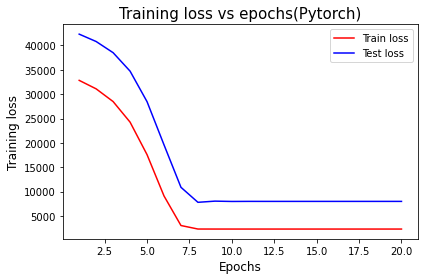

In [11]:
import matplotlib.pyplot as plt
titleFontSize = 15
labelFontSize = 12
tickFontSize = 10
legendFontSize = 10
labelStr = "size = "
yLabel = "% of test points with lower error"
xLabel = "Error %"
count_arr = [i for i in range(1, len(train_loss_array) + 1)]
plt.plot(count_arr, train_loss_array, label = "Train loss", color='red')
plt.plot(count_arr, test_loss_array, label = "Test loss", color='blue')
plt.title("Training loss vs epochs(Pytorch)", fontsize=titleFontSize)
plt.xlabel("Epochs", fontsize=labelFontSize)
plt.ylabel("Training loss", fontsize=labelFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.legend(prop={"size": legendFontSize})
# plt.savefig("pytorch_loss.png")

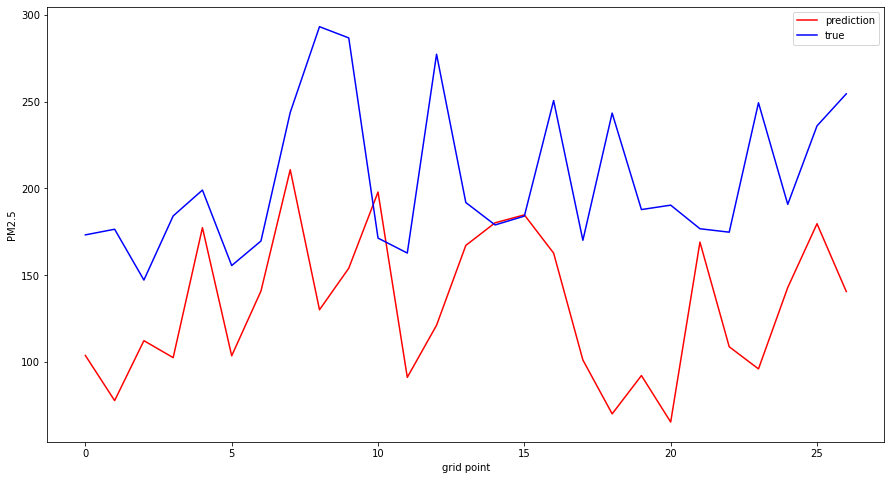

In [12]:
#all test result visualization
test_output, _,_ = eval(model, train_data, test_data)
test_output = test_output.detach().numpy()
fig1 = plt.figure(figsize=(15, 8))
test_true = test_data[:, 0]
a_pred = test_output[test_output>0]
a_true = test_true[test_true>0]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("grid point")
plt.ylabel("PM2.5")
plt.legend(loc="best", fontsize=10)
plt.show()